In [1]:
import os
import shutil
## lazy imports ala fastai2 style (needed for nice print functionality)
from fastai.basics import *
from fastai.tabular.all import *

## import AR-Net
import arnet

%matplotlib inline

In [2]:
## notebook settings
verbose = True
save = False
cleanup = True

created_ar_data = True

data_path = '../ar_data'
data_name = 'ar_3_ma_0_noise_0.100_len_10000'
results_path = '../results'

In [3]:
## Load data
if created_ar_data:
    ## if created AR data with create_ar_data, we can use the helper function:
    df, data_config = arnet.load_from_file(data_path, data_name, load_config=True, verbose=verbose)
else:
    ## else we can manually load any file that stores a time series, for example:
    df = pd.read_csv(os.path.join(data_path, data_name + '.csv'), header=None, index_col=False)

loaded series from file
data_config {'samples': 10000, 'noise_std': 0.1, 'ar_order': 3, 'ma_order': 0, 'ar_params': [0.2, 0.3, -0.5], 'ma_params': []}
(10000, 1)
          0
0  0.114610
1  0.027092
2 -0.015263
3 -0.125719
4 -0.279195


In [4]:
#### Hyperparameters
n_epoch = 15
valid_p = 0.2
n_forecasts = 1  # Note: if more than one, must have a list of ar_param for each forecast target.
sparsity = 0.3  # guesstimate

## if we know the true AR parameters:
if created_ar_data: 
    ## sparse AR: (for non-sparse, set sparsity to 1.0)
    ar_order = int(1/sparsity * data_config["ar_order"])     
    ## to compute stats
    ar_params = arnet.pad_ar_params([data_config["ar_params"]], ar_order, n_forecasts)
else:
    ar_params = None
    ar_order = 3 

In [5]:
#### Init Model
learn = arnet.init_ar_learner(
    series=df,
    ar_order=ar_order,
    n_forecasts=n_forecasts,
    valid_p=valid_p,
    sparsity=sparsity,
    ar_params=ar_params,
    verbose=verbose,
)

tabularized df
df columns ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_0']
df shape (9990, 11)
estimated noise of series 0.12853080551811422
split on idx:  7992
split sizes:  [7992, 1998]
cont var num 10 ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
reg lam:  0.005998104257511998
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)


lr at minimum: 0.04570882022380829


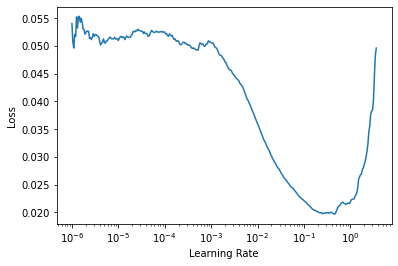

In [6]:
## find Learning Rate
lr_at_min, _ = learn.lr_find(start_lr=1e-6, end_lr=1e2, num_it=400)
print("lr at minimum: {}".format(lr_at_min))

In [7]:
#### Run Model
## if you know the best learning rate:
# learn.fit(n_epoch, 1e-2)
## else use onecycle
learn.fit_one_cycle(n_epoch=n_epoch, lr_max=lr_at_min/10)

epoch,train_loss,valid_loss,mae,sTPE of AR coeff,time
0,0.031085,0.021893,0.119834,54.384563,00:01
1,0.013529,0.010846,0.083358,18.060856,00:01
2,0.012378,0.010164,0.080609,5.892164,00:01
3,0.012762,0.010338,0.081312,9.736054,00:01
4,0.013084,0.010232,0.080985,7.716311,00:01
5,0.012711,0.010290,0.081196,10.196399,00:01
6,0.012592,0.010251,0.081023,7.288769,00:01
7,0.012658,0.010218,0.080901,5.527937,00:01
8,0.012589,0.010339,0.081309,12.008403,00:01
9,0.012473,0.010184,0.080733,6.603688,00:01


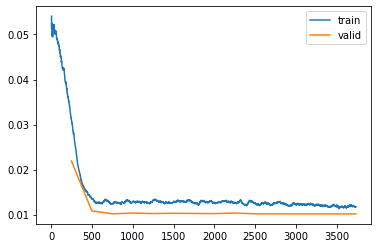

In [8]:
learn.recorder.plot_loss()

In [9]:
#### Look at Coeff
coeff = arnet.coeff_from_model(learn.model)
if created_ar_data: 
    print("ar params", arnet.nice_print_list(ar_params))
print("model weights", arnet.nice_print_list(coeff))
# should be [0.20, 0.30, -0.50, ...]

ar params [['0.200', '0.300', '-0.500', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']]
model weights [['0.176', '0.278', '-0.465', '-0.000', '-0.000', '0.000', '-0.000', '-0.000', '-0.000', '0.000']]


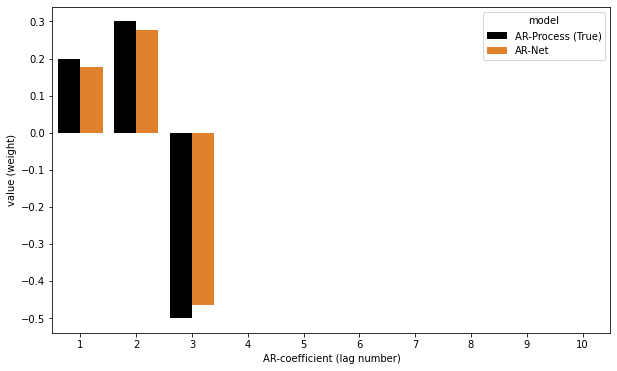

In [10]:
if created_ar_data: 
    arnet.plot_weights(
        ar_val=len(ar_params[0]),
        weights=coeff[0],
        ar=ar_params[0],
        save=save,
        savedir=results_path
    )

In [11]:
preds, y = learn.get_preds()

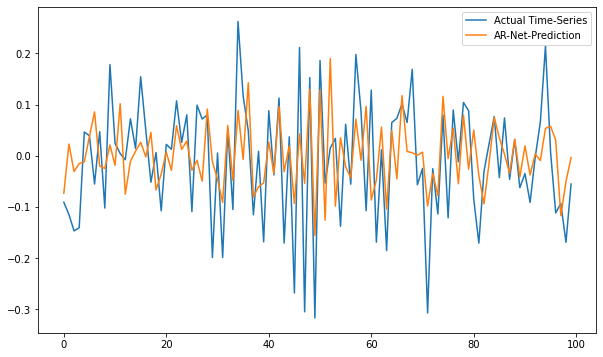

In [12]:
arnet.plot_prediction_sample(preds, y, num_obs=100, save=save, savedir=results_path)

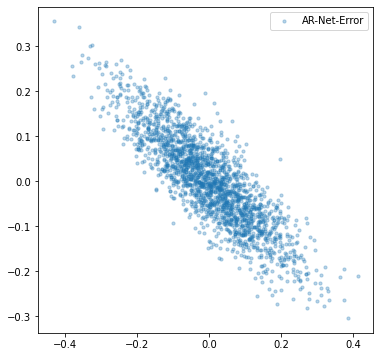

In [13]:
arnet.plot_error_scatter(preds, y, save=save, savedir=results_path)

In [14]:
#### Extras ####

In [15]:
## Optional:save and create inference learner
if save:
    learn.freeze()
    if not os.path.exists(results_path): 
        os.makedirs(results_path)
    model_name = "ar{}_sparse_{:.3f}_ahead_{}_epoch_{}.pkl".format(ar_order, sparsity, n_forecasts, n_epoch)
    learn.export(fname=os.path.join(results_path, model_name))
    ## can be loaded like this
    learn = arnet.load_learner(fname=os.path.join(results_path, model_name), cpu=True)

In [16]:
## can unfreeze the model and fine_tune
learn.unfreeze()
learn.fit_one_cycle(5, lr_at_min/100)

epoch,train_loss,valid_loss,mae,sTPE of AR coeff,time
0,0.011923,0.010154,0.080592,4.737513,00:01
1,0.012069,0.010158,0.080606,5.188836,00:01
2,0.012528,0.010157,0.080622,5.201859,00:01
3,0.012206,0.010158,0.080608,4.697365,00:01
4,0.011685,0.010158,0.080611,4.652950,00:01


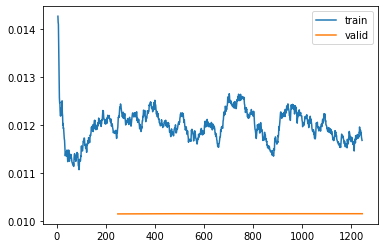

In [17]:
learn.recorder.plot_loss()

ar params [['0.200', '0.300', '-0.500', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']]
model weights [['0.176', '0.278', '-0.465', '-0.000', '-0.000', '0.000', '-0.000', '-0.000', '-0.000', '0.000']]
model weights2 [['0.173', '0.274', '-0.464', '0.000', '0.000', '0.000', '0.000', '-0.000', '0.000', '0.000']]


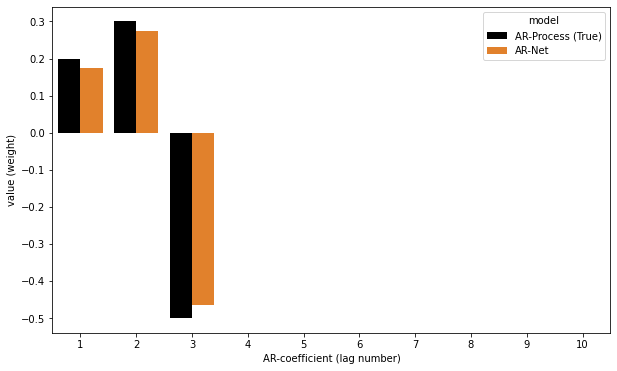

In [18]:
coeff2 = arnet.coeff_from_model(learn.model)
if created_ar_data: 
    print("ar params", arnet.nice_print_list(ar_params))
print("model weights", arnet.nice_print_list(coeff))
print("model weights2", arnet.nice_print_list(coeff2))
if created_ar_data: 
    arnet.plot_weights(
        ar_val=len(ar_params[0]),
        weights=coeff2[0],
        ar=ar_params[0],
        save=save,
        savedir=results_path
    )

In [19]:
# cleanup
if save and cleanup:
    shutil.rmtree(results_path)